### Установки

In [1]:
!pip install navec
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar -P ./data/models

--2023-04-23 15:54:12--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘./data/models/navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  15.9MB/s    in 3.2s    

2023-04-23 15:54:16 (15.9 MB/s) - ‘./data/models/navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



### Описание задачи

**Задача:** разработать модель, которая будет способна по паре `текст документа` и `пункт анкеты` извлекать из текста документа нужный фрагмент текста. 
Обучив модель, добавьте в файл `test.json` поле `extracted_part` в том же формате, что и в файле `train.json`. Новый файл назовите `predictions.json`



Данные для обучения в формате json имеют следующие поля:
- `id`: int - id документа
-  `text`: str - текст документа, в котором может содержаться фрагмент текста, соответствующий пункту анкеты из поля `label`
- `label`: str - название пункта анкеты. Может принимать одно из двух значений: `обеспечение исполнения контракта` или `обеспечение гарантийных обязательств`

```
`extracted_part`: dict следующего формата:
    
    {
        'text': [фрагмент текста из поля `text`, соответствующий пункту анкеты], 
        'answer_start': [индекс символа начала фрагмента текста в тексте документа],
        'answer_end': [индекс символа конца фрагмента текста в тексте документа]
    }
```

Для демонстрации работы модели используйте данные из файла `test.json`. В нем есть все те же поля, что и в файле `train.json`, кроме поля `extracted_part` - именно его вам и нужно будет добавить,
для того, чтобы мы смогли оценить качество вашей модели.

### Импорты

In [27]:
from research.utils import (split_df_texts_by_sentences, 
                            get_extracted_part_from_dataset,
                            lemmatize_splitted_df_sentences,
                            get_sentence_vectors_from_lemmatized_text) 

from sklearn.model_selection import train_test_split
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from navec import Navec
import pandas as pd
import numpy as np
import joblib
import json
import nltk

In [42]:
path = './data/models/navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)
nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Применение модели к трейну, замер accuracy

In [5]:
df_train = pd.read_json('./data/train.json', encoding='utf-8')  # загружаем данные из train.json
df_train.head()

,id,text,label,extracted_part
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить обесп...
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...


Загрузим модели для классификации предложений в зависимости от label (подробно в reserch/base_model)

In [6]:
# загрузка обученных моделей
contract_enforcement_model = joblib.load('./data/models/contract_enforcement_xgb_model.joblib')
garantee_enforcement_model = joblib.load('./data/models/garantee_enforcement_xgb_model.joblib')

In [8]:
df_splitted = split_df_texts_by_sentences(df_train.copy())  # делим тексты на предложения
df_lemmatized = lemmatize_splitted_df_sentences(df_splitted.copy(), stopwords_ru, morph)  # приводим слова в предложениях к нормальному виду

In [9]:
df_splitted.to_json('./data/train_splitted.json')
df_lemmatized.to_json('./data/train_lemmatized.json')

Далее для применения моделей необходимо превратить "лемматизированные" предложения в векторы предложений. С этим нам поможет библиотека Navec. Navec - это библиотека предварительно подготовленных ембендингов слов для русского языка. 

Подробнее: https://github.com/natasha/navec?ysclid=lgi8rvqlyo416346758

Такой векторизатор я реализовал в виде функции get_sentence_vectors_from_lemmatized_text в модуле utils. (см research/utils.py) 

Далее нам необходимо реализовать функции для предсказания, т.к. модели две 

In [8]:
def get_predicted_sentence_index_for_contract_enforcement(df_lemmatized_object, min_rate=0.4):
  shape = 83  # определяем максимальную длину вектора предожения
  vectorized_text = get_sentence_vectors_from_lemmatized_text(df_lemmatized_object['text'], shape, navec)  # функция создаёт векторы предложений из их списка
  # в итоге на выходе получаем векторизованный текст


  max_probability=0 
  index = -1
  try:
    # проходим по каждому предложению и считаем "вероятность" принадлежности его к целевому классу
    for i in range(len(vectorized_text)):
      vector = vectorized_text[i]
      vector = np.array(vector)
      vector = vector.reshape((1, shape))  
      pred = contract_enforcement_model.predict_proba(vector)[0][1]

      # сохраняем индекс предложения с наибольшей "вероятностью"
      if pred > max_probability and pred > min_rate:
        max_probability = pred
        index = i
  except Exception as e:
    print(vector.shape, vector, df_lemmatized_object['label'], e)  # добавляем дебаг-логирование
  
  return index, max_probability

И такую же функцию для лейбла "обеспечение гарантийных обязательств"

In [9]:
def get_predicted_sentence_index_for_garantee_enforcement(df_lemmatized_object, min_rate=0.8):
  shape = 83  # определяем максимальную длину вектора предожения

  # создание векторов предложений
  vector_text = get_sentence_vectors_from_lemmatized_text(df_lemmatized_object['text'], shape, navec)

  max_probability=0
  index = -1

  try: 
    for i in range(len(vector_text)):
      sentence_vector = vector_text[i]
      sentence_vector = np.array(sentence_vector)
      sentence_vector = sentence_vector.reshape((1, shape))
      # применение модели к вектору предложения
      pred = garantee_enforcement_model.predict_proba(sentence_vector)[0][1]

      # сохранение наилучшего результата
      if pred > max_probability and pred > min_rate:
        max_probability = pred
        index = i
  except Exception as e:
    print(sentence_vector.shape, sentence_vector, df_lemmatized_object['label'], e)

  return index, max_probability

Далее напишем функцию для построчной обработки датафрейма и передачи текстов в функции в зависимости от лейблов

In [10]:
def predict_sentence(df_lemmatized, df_splitted, min_garantee_enforcement_rate=0.8, min_contract_enforcement_rate=0.4):
  """
  Input: pd.DataFrame с нормализаванными предложениями. 
  Пример поля ['text']:
  [['способ', 'определение', 'поставщик', 'подрядчик', 'исполнитель'], ['электронный', 'аукцион'], ....]

  Output: pred:list список предсказаний. 
  """

  pred = []
  # пробегаемся по текстам и отправляем их в соответствующую label модель
  for i in range(len(df_lemmatized)):
    if df_lemmatized.loc[i, 'label'] == 'обеспечение исполнения контракта':
      
      index, _ = get_predicted_sentence_index_for_contract_enforcement(df_lemmatized.loc[i, :], min_contract_enforcement_rate)
      pred.append(df_splitted.loc[i, 'text'][index] if index != -1 else None)  # добавляем искомое предложение в pred

    elif df_lemmatized.loc[i, 'label'] == 'обеспечение гарантийных обязательств': 
      index, _ = get_predicted_sentence_index_for_garantee_enforcement(df_lemmatized.loc[i, :], min_garantee_enforcement_rate)
      pred.append(df_splitted.loc[i, 'text'][index] if index != -1 else None)  # добавляем искомое предложение в pred

    else:
      print('Неверное значение label')
  return pred

Протестируем полученные модели

In [11]:
%%time
predictions = predict_sentence(df_lemmatized, df_splitted, min_garantee_enforcement_rate=0.8)  # предсказываем искомые предложения

CPU times: user 4min 6s, sys: 2.8 s, total: 4min 9s
Wall time: 3min 8s


In [12]:
def accuracy_count(df_train, predictions, save_errors=False):
  # проверяем объекты на входе
  assert len(df_train) == len(predictions), f'Объекты должны иметь одинаковую длину: df_train: {len(df_train)}, predictions: {len(predictions)}'
  counter = 0
  i = 0
  # считаем accuracy
  for extracted_part, pred in zip(df_train.loc[:, 'extracted_part'].values, predictions):
    if pred == extracted_part['text'][0] or (pred is None and  extracted_part['text'][0] == ''):
      counter += 1

    else:
      if save_errors: 
        query = f"""
        index = {i}\n
        prediction: {pred}\n
        target: {extracted_part['text'][0]}\n\n
        """
        with open('./data/errors.txt', 'a') as f:
          f.write(query)
    i += 1
      
  return counter/len(df_train)

In [13]:
accuracy_count(df_train, predictions, True)

0.6987215119510839

попробуем подобрать параметры min_rate для модели garantee_enforcement

In [14]:
def min_rate_best_value_search(grid):
  # принимаем список из значений, выводим график зависимости accurcy от rate
  accuracy_list = []
  for i in grid:
    predictions = predict_sentence(df_lemmatized, df_splitted, min_garantee_enforcement_rate=i)
    accuracy_list.append(accuracy_count(df_train, predictions))
  plt.figure(figsize=(7, 7))
  plt.plot(grid, accuracy_list)
  plt.show()

In [41]:
# garantee_enforcement_rate_grid = np.arange(0.92, 1, 0.02)  # итератор для поиска наилучшего порога в garantee_enforcement_model
# min_rate_best_value_search(garantee_enforcement_rate_grid)

После окончания работы получаем такой график: 
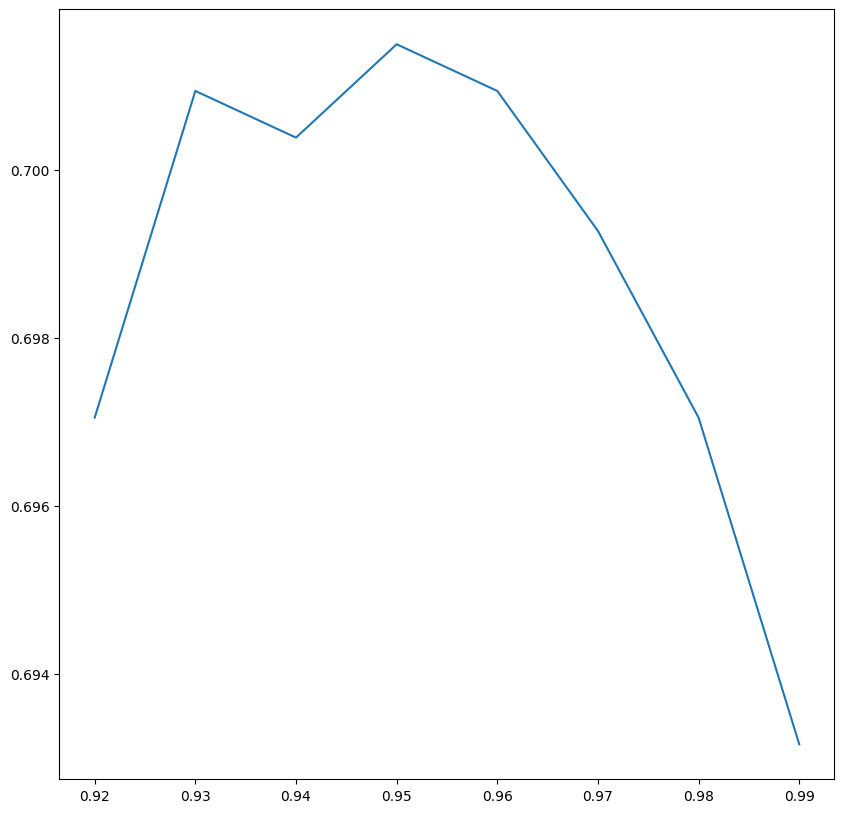

таким образом из графика видим, что значение min_garantee_enforcement_rate=0.95 - оптимально

In [15]:
%%time
predictions = predict_sentence(df_lemmatized, df_splitted, min_garantee_enforcement_rate=0.95)  # делаем предсказание с min_rate = 0.95

CPU times: user 3min 15s, sys: 2.37 s, total: 3min 17s
Wall time: 1min 55s


In [16]:
accuracy_count(df_train, predictions)

0.7031684269038355

### Предсказание test.json

In [17]:
# загрузка данных
df_test = pd.read_json('./data/test.json', encoding='utf-8')
df_test.head()

,id,text,label
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта
3,274660397,Идентификационный код закупки: 222631202689463...,обеспечение исполнения контракта
4,732742591,Идентификационный код закупки: 222637800031163...,обеспечение исполнения контракта


In [18]:
df_test.shape

(318, 3)

Теперь, перед тем как "скормить" данные модели, нужно аналогично трейну разделить их на предложения и привести слова в предложениях к нормальным формам, для правильной векторизации

In [19]:
df_test_splitted = split_df_texts_by_sentences(df_test.copy())
df_test_lemmatized = lemmatize_splitted_df_sentences(df_test_splitted.copy(), stopwords_ru, morph)

Далее передаём наши данные в функцию predict_sentence

In [20]:
test_predictions = predict_sentence(df_test_lemmatized, df_test_splitted, min_garantee_enforcement_rate=0.95)

Далее необходимо привести предсказания к формату сдачи задания. Например: 
```
"extracted_part": {
      "text": [
        "Поставщик должен предоставить обеспечение исполнения контракта в размере 10 % от цены Контракта."
      ],
      "answer_start": [
        1222
      ],
      "answer_end": [
        1318
      ]
    }
```

In [21]:
df_test_extracted_part = get_extracted_part_from_dataset(df_test, test_predictions)  # формируем список словарей для ответа

In [22]:
df_test_extracted_part_series = pd.Series(df_test_extracted_part)  # создаём объект Series из списка словарей
df_test_extracted_part_series

0      {'text': ['Размер обеспечения исполнения Контр...
1      {'text': ['Размер обеспечения исполнения контр...
2      {'text': ['Размер обеспечение исполнения контр...
3      {'text': ['Размер обеспечение исполнения контр...
4      {'text': ['Размер обеспечение исполнения контр...
                             ...                        
313    {'text': [''], 'answer_start': [0], 'answer_en...
314    {'text': ['Размер обеспечения гарантийных обяз...
315    {'text': [''], 'answer_start': [0], 'answer_en...
316    {'text': [''], 'answer_start': [0], 'answer_en...
317    {'text': [''], 'answer_start': [0], 'answer_en...
Length: 318, dtype: object

In [23]:
df_test['extracted_part'] = df_test_extracted_part_series  # добавляем объект Series в колонку extracted_part

In [24]:
df_test.sample(5)

,id,text,label,extracted_part
189,647279640,ПРОЕКТ Муниципальный контракт № ______________...,обеспечение гарантийных обязательств,"{'text': [''], 'answer_start': [0], 'answer_en..."
178,967546466,ПРОЕКТ ДОГОВОРА ПОСТАВКИ №___ г. Псков «______...,обеспечение исполнения контракта,{'text': ['Размер обеспечения составляет: а) д...
164,326205870,33 АО «ИТМО Хайпарк» ОГРН 1177847389389 191124...,обеспечение исполнения контракта,"{'text': ['В случае, если размер аванса превыш..."
210,108391202,«УТВЕРЖДАЮ» И.о. директора Читинского филиала ...,обеспечение гарантийных обязательств,{'text': ['Размер обеспечения гарантийных обяз...
221,430216673,Извещение о проведении электронного аукциона д...,обеспечение гарантийных обязательств,{'text': ['Размер обеспечения гарантийных обяз...


### Сохранение результатов

In [43]:
df_test.to_json('predictions.json', orient='records', indent=2)  # сохраняем в json

### Выводы по исследованию

По ходу исследования была реализована модель градиентного бустинга для разметки фрагментов текста. Максимальный результат accuracy на трейне показала пара моделей XGBoost - 70.3% попаданий. 

Улучшить результат можно: 

*   Добавлением новых фич в обучающую выборку
*   Проработкой обучающей выборки для моделей
*   Использовать более сложные модели, нейронные сети
*   Улучшением качества разбиения текстов
*   Использовать готовые модели nlp для решения задачи NER, text summarization, information extraction (spacy и др.)








Также плохо повлияло на метрики неидеальное разбиение текстов на фрагменты, найден баг в разбиении предложений, не повлиявший на предсказания на тестовой выборке. При разбиении текста на фрагменты теряется изначальное количество пробелов в тексте. Т.е. если в тексте между словами стоит больше одного пробела, после разделения остаётся один. 

Далее для развития проекта можно реализовать интерфейс, оптимизировать скорость работы и улучшить качество самой модели. 